## Análisis Exploratorio

### Importación de librerías y estadísticas de las imágenes

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ruta_base = "."

# ANÁLISIS EXPLORATORIO
estadisticas = {
    "dataset": [],
    "clase": [],
    "cantidad_imagenes": []
}

dimensiones_por_clase = defaultdict(list)
formatos_por_clase = defaultdict(set)

for tipo in ["train", "test"]:
    ruta_tipo = os.path.join(ruta_base, tipo)
    clases = os.listdir(ruta_tipo)

    for clase in clases:
        ruta_clase = os.path.join(ruta_tipo, clase)
        imagenes = os.listdir(ruta_clase)

        estadisticas["dataset"].append(tipo)
        estadisticas["clase"].append(clase)
        estadisticas["cantidad_imagenes"].append(len(imagenes))

        for img_nombre in imagenes[:20]:
            img_path = os.path.join(ruta_clase, img_nombre)
            try:
                with Image.open(img_path) as img:
                    dimensiones_por_clase[clase].append(img.size)
                    formatos_por_clase[clase].add(img.format)
            except Exception as e:
                print(f"Error leyendo {img_path}: {e}")

### Distribuciones y balanceo de las clases

In [ ]:
df = pd.DataFrame(estadisticas)
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="clase", y="cantidad_imagenes", hue="dataset")
plt.title("Distribución de clases (train/test)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("distribucion_clases.png")
plt.show()

print("\nRecuento de clases:")
print(df.groupby(["dataset", "clase"])["cantidad_imagenes"].sum())
train_counts = df[df["dataset"] == "train"]["cantidad_imagenes"]
desbalanceo = train_counts.max() - train_counts.min()
print(f"\nDiferencia entre clases más y menos numerosas: {desbalanceo}")

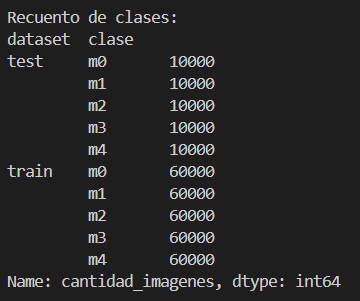

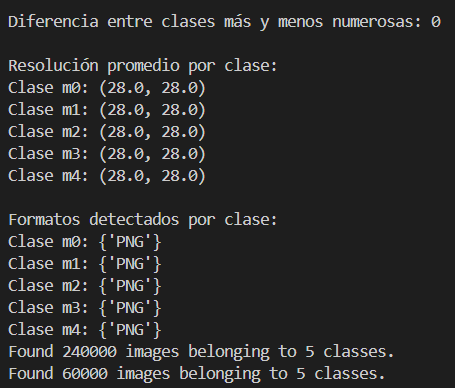

### Resolución promedio de las imágenes 

In [ ]:
print("\nResolución promedio por clase:")
for clase, dims in dimensiones_por_clase.items():
    if dims:
        df_dims = pd.DataFrame(dims, columns=["ancho", "alto"])
        promedio = df_dims.mean().round(2)
        print(f"Clase {clase}: {tuple(promedio)}")

print("\nFormatos detectados por clase:")
for clase, formatos in formatos_por_clase.items():
    print(f"Clase {clase}: {formatos}")

### Ejemplos de cada clase 

In [ ]:
def mostrar_ejemplos(ruta, clase, n=5):
    ruta_clase = os.path.join(ruta, clase)
    imagenes = os.listdir(ruta_clase)[:n]
    plt.figure(figsize=(15, 3))
    for i, nombre in enumerate(imagenes):
        img_path = os.path.join(ruta_clase, nombre)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(clase)
        plt.axis('off')
    plt.suptitle(f"Ejemplos de la clase: {clase}")
    plt.show()

for clase in os.listdir(os.path.join(ruta_base, "train")):
    mostrar_ejemplos(os.path.join(ruta_base, "train"), clase)

### Preprocesamiento de los datos

In [ ]:
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_gen = datagen.flow_from_directory(
    directory=os.path.join(ruta_base, "train"),
    target_size=(64, 64),
    class_mode='sparse',
    batch_size=32,
    subset='training'
)
val_gen = datagen.flow_from_directory(
    directory=os.path.join(ruta_base, "train"),
    target_size=(64, 64),
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)

num_clases = len(train_gen.class_indices)

## Creación de los Modelos 

### Modelo 1: CNN Simple

In [ ]:
modelo_1 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])
modelo_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelo_1.fit(train_gen, validation_data=val_gen, epochs=10)

### Modelo 2: Transfer Learning (MobileNetV2)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
base_model.trainable = False
modelo_2 = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_clases, activation='softmax')
])
modelo_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelo_2.fit(train_gen, validation_data=val_gen, epochs=10)

### Red Neuronal

In [ ]:
modelo_3 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])
modelo_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelo_3.fit(train_gen, validation_data=val_gen, epochs=10)

### Evaluación de los modelos

In [ ]:
print("\nEvaluación final de modelos:")
_, acc1 = modelo_1.evaluate(val_gen)
_, acc2 = modelo_2.evaluate(val_gen)
_, acc3 = modelo_3.evaluate(val_gen)

print(f"CNN simple: {acc1:.2%}")
print(f"Transfer Learning: {acc2:.2%}")
print(f"Red neuronal simple: {acc3:.2%}")

### Modelo nuevo KNN con SKLEARN

In [ ]:
# Generador sin augmentación
datagen_no_aug = ImageDataGenerator(rescale=1./255)

# Cargar imágenes de entrenamiento sin augmentación

train_gen_no_aug = datagen_no_aug.flow_from_directory(
    os.path.join(ruta_base, 'train'),
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


# Obtener datos y etiquetas del generador
X_train_no_aug, y_train_no_aug = next(iter(train_gen_no_aug))
for _ in range(len(train_gen_no_aug) - 1):
    x_batch, y_batch = next(iter(train_gen_no_aug))
    X_train_no_aug = np.concatenate((X_train_no_aug, x_batch), axis=0)
    y_train_no_aug = np.concatenate((y_train_no_aug, y_batch), axis=0)

# Cargar imágenes de prueba sin augmentación
test_gen_no_aug = datagen_no_aug.flow_from_directory(
    os.path.join(ruta_base, 'test'),
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

X_test_no_aug, y_test_no_aug = next(iter(test_gen_no_aug))
for _ in range(len(test_gen_no_aug) - 1):
    x_batch, y_batch = next(iter(test_gen_no_aug))
    X_test_no_aug = np.concatenate((X_test_no_aug, x_batch), axis=0)
    y_test_no_aug = np.concatenate((y_test_no_aug, y_batch), axis=0)

# Aplanar imágenes y etiquetas
X_train_flat = X_train_no_aug.reshape(X_train_no_aug.shape[0], -1)
X_test_flat = X_test_no_aug.reshape(X_test_no_aug.shape[0], -1)
y_train_labels = np.argmax(y_train_no_aug, axis=1)
y_test_labels = np.argmax(y_test_no_aug, axis=1)

# Entrenar y evaluar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_flat, y_train_labels)
y_pred = knn.predict(X_test_flat)

accuracy = accuracy_score(y_test_labels, y_pred)
print(f"KNN sin augmentación: {accuracy * 100:.2f}%")

### Mismo modelo con augmentación

In [ ]:
# Extraer datos para KNN (limitado a evitar problemas de memoria)
X_train_knn, y_train_knn = [], []
for i in range(300):
    x, y = next(iter(train_gen))
    X_train_knn.append(x)
    y_train_knn.append(y)

X_train_knn = np.concatenate(X_train_knn)
y_train_knn = np.concatenate(y_train_knn)
X_train_knn_flat = X_train_knn.reshape((X_train_knn.shape[0], -1))

X_val_knn, y_val_knn = [], []
for i in range(50):
    x, y = next(iter(val_gen))
    X_val_knn.append(x)
    y_val_knn.append(y)

X_val_knn = np.concatenate(X_val_knn)
y_val_knn = np.concatenate(y_val_knn)
X_val_knn_flat = X_val_knn.reshape((X_val_knn.shape[0], -1))

# Entrenamiento y evaluación
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn.fit(X_train_knn_flat, y_train_knn)
pred_knn = knn.predict(X_val_knn_flat)
acc_knn = accuracy_score(y_val_knn, pred_knn)
print(f"KNN con augmentación: {acc_knn:.2%}")